In [1]:
import os, sys
# ability to fetch scripts
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '../..')))
from helper_functions.parsing import *
from helper_functions.plot_params import *
from helper_functions.external_functions import logit_transform

import numpy as np
import pandas as pd
import scipy.optimize as optimize
import torch
import swifter

In [2]:
def chi_square(n_scalers):
    sum_ = 0
    for i in range(len(bins_to_fit)-1):
        for j in range(len(bins_to_fit)-1):
            if counts_rd_to_fit[i,j] > 0:
                sum_+= (counts_rd_to_fit[i,j] - n_scalers[0]*counts_noise_to_fit[i,j] - n_scalers[1]*counts_muon_to_fit[i,j] - n_scalers[2]*counts_neutrino_to_fit[i,j])**2/counts_rd_to_fit[i,j]
            elif np.max([counts_noise_to_fit[i,j],counts_muon_to_fit[i,j],counts_neutrino_to_fit[i,j]]) >0:
                sum_+= (counts_rd_to_fit[i,j] - n_scalers[0]*counts_noise_to_fit[i,j] - n_scalers[1]*counts_muon_to_fit[i,j] - n_scalers[2]*counts_neutrino_to_fit[i,j])**2/np.max([counts_noise_to_fit[i,j],counts_muon_to_fit[i,j],counts_neutrino_to_fit[i,j]])
            else:
                sum_+=0
    return sum_

In [3]:
results_rd = pd.read_csv("/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_stop_track_muon/Inference/pid_Leon_MC_Full_db.csv").sort_values('event_no').reset_index(drop = True)
results_mc = pd.read_csv("/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_stop_track_muon/Inference/pid_Leon_RD_results_new_model.csv").sort_values('event_no').reset_index(drop = True)

In [4]:
bins_to_use = np.linspace(-17,17,100)
bins_to_fit = np.linspace(-12,17,100) #bins_to_use
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

In [5]:
class_options = {1: 0, -1: 0, 13: 1, -13: 1, 12: 2, -12: 2, 14: 2, -14: 2, 16: 2, -16: 2}
pid_transform = torch.tensor([class_options[int(value)] for value in results_mc["pid"]])

In [31]:
keys = ["noise", "muon", "neutrino"]
noise_logits, muon_logits, neutrino_logits = dict(), dict(), dict()
mask = dict()
# loop over dataset
for key in keys:
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        mask[item] = results_mc[f'pid_{key}_pred'] == class_type
        locals()[f"{key}_logits"][item] = pd.Series(mask[item]).swifter.apply(logit_transform);
    locals()[f"{key}_logits"]["RD"] = pd.Series(results_rd[f'pid_{key}_pred']).swifter.apply(logit_transform);

In [29]:
noise_logits

{'noise': 0         -13.81551
 1         -13.81551
 2         -13.81551
 3         -13.81551
 4         -13.81551
              ...   
 1420704   -13.81551
 1420705   -13.81551
 1420706   -13.81551
 1420707   -13.81551
 1420708   -13.81551
 Name: pid_noise_pred, Length: 1420709, dtype: float64,
 'muon': 0         -13.81551
 1         -13.81551
 2         -13.81551
 3         -13.81551
 4         -13.81551
              ...   
 1420704   -13.81551
 1420705   -13.81551
 1420706    13.81551
 1420707   -13.81551
 1420708   -13.81551
 Name: pid_noise_pred, Length: 1420709, dtype: float64,
 'neutrino': 0         -13.81551
 1         -13.81551
 2         -13.81551
 3         -13.81551
 4         -13.81551
              ...   
 1420704   -13.81551
 1420705   -13.81551
 1420706   -13.81551
 1420707   -13.81551
 1420708   -13.81551
 Name: pid_noise_pred, Length: 1420709, dtype: float64,
 'RD': 0            5.230409
 1            7.414763
 2           13.815510
 3            6.725921
 4          

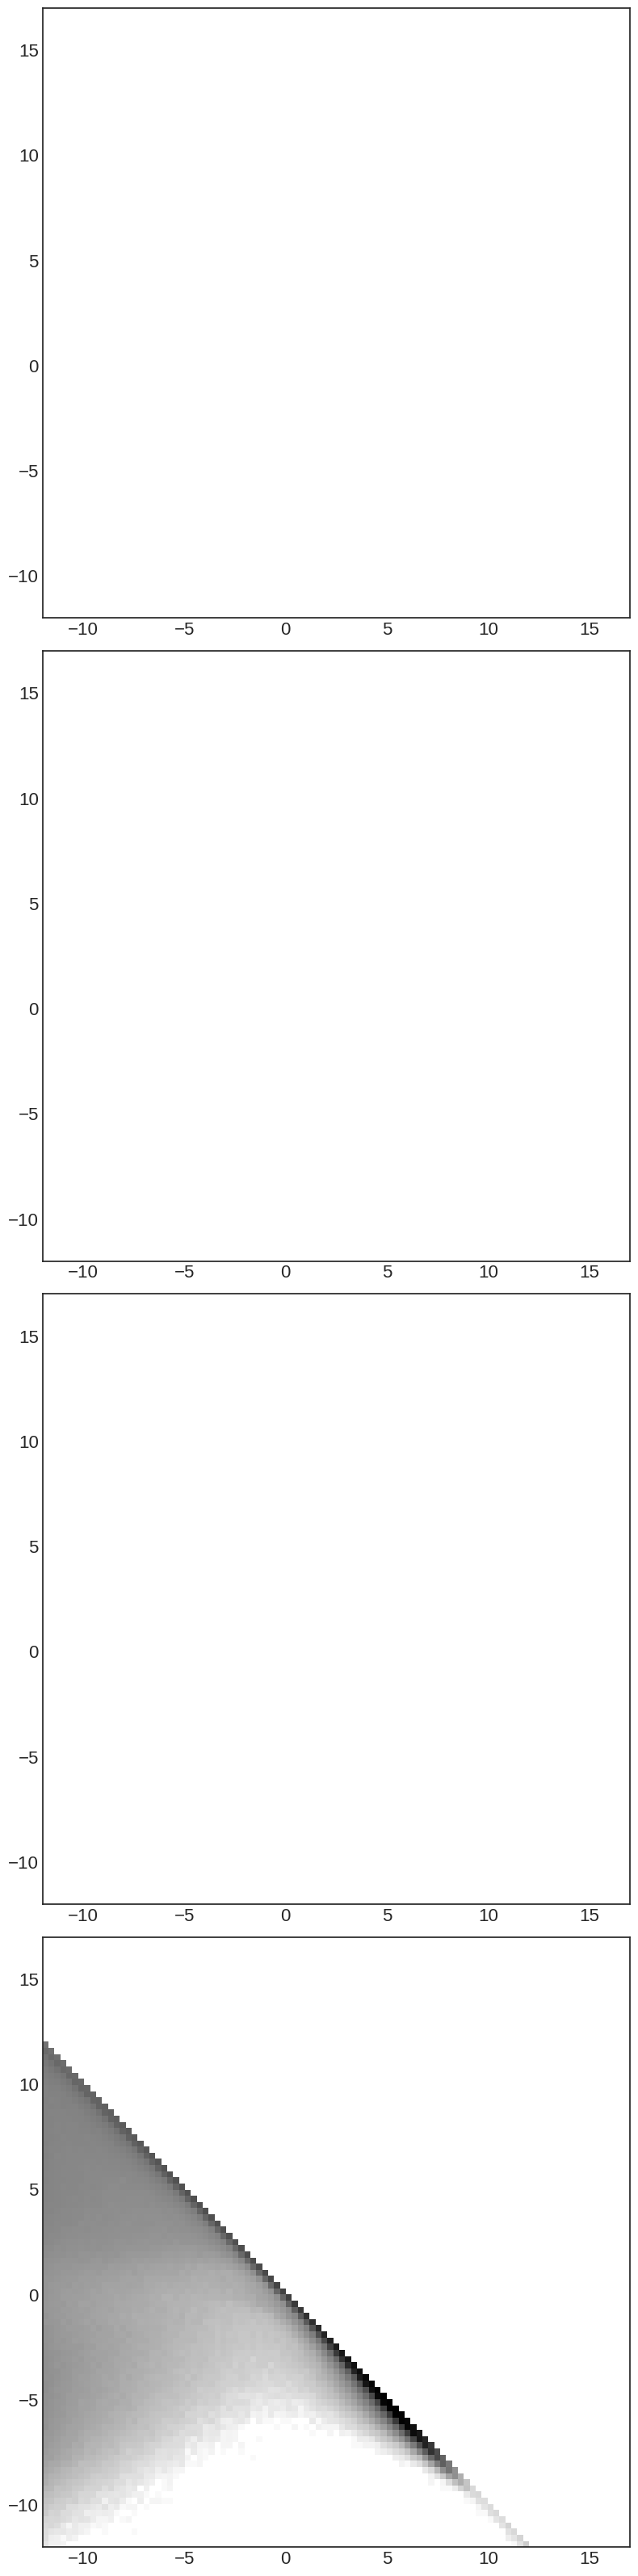

In [25]:
fig, axs = plt.subplots(4,1,sharex=False,figsize=(8, 32))
counts_noise_to_fit,_,_,_ = axs[0].hist2d(noise_logits['noise'],neutrino_logits['noise'],bins_to_fit,norm=colors.LogNorm())
counts_muon_to_fit,_,_,_ = axs[1].hist2d(noise_logits['muon'],neutrino_logits['muon'],bins_to_fit,norm=colors.LogNorm())
counts_neutrino_to_fit,_,_,_ = axs[2].hist2d(noise_logits['neutrino'],neutrino_logits['neutrino'],bins_to_fit,norm=colors.LogNorm())
counts_rd_to_fit,_,_,_ = axs[3].hist2d(noise_logits['RD'],neutrino_logits['RD'],bins_to_fit,norm=colors.LogNorm())

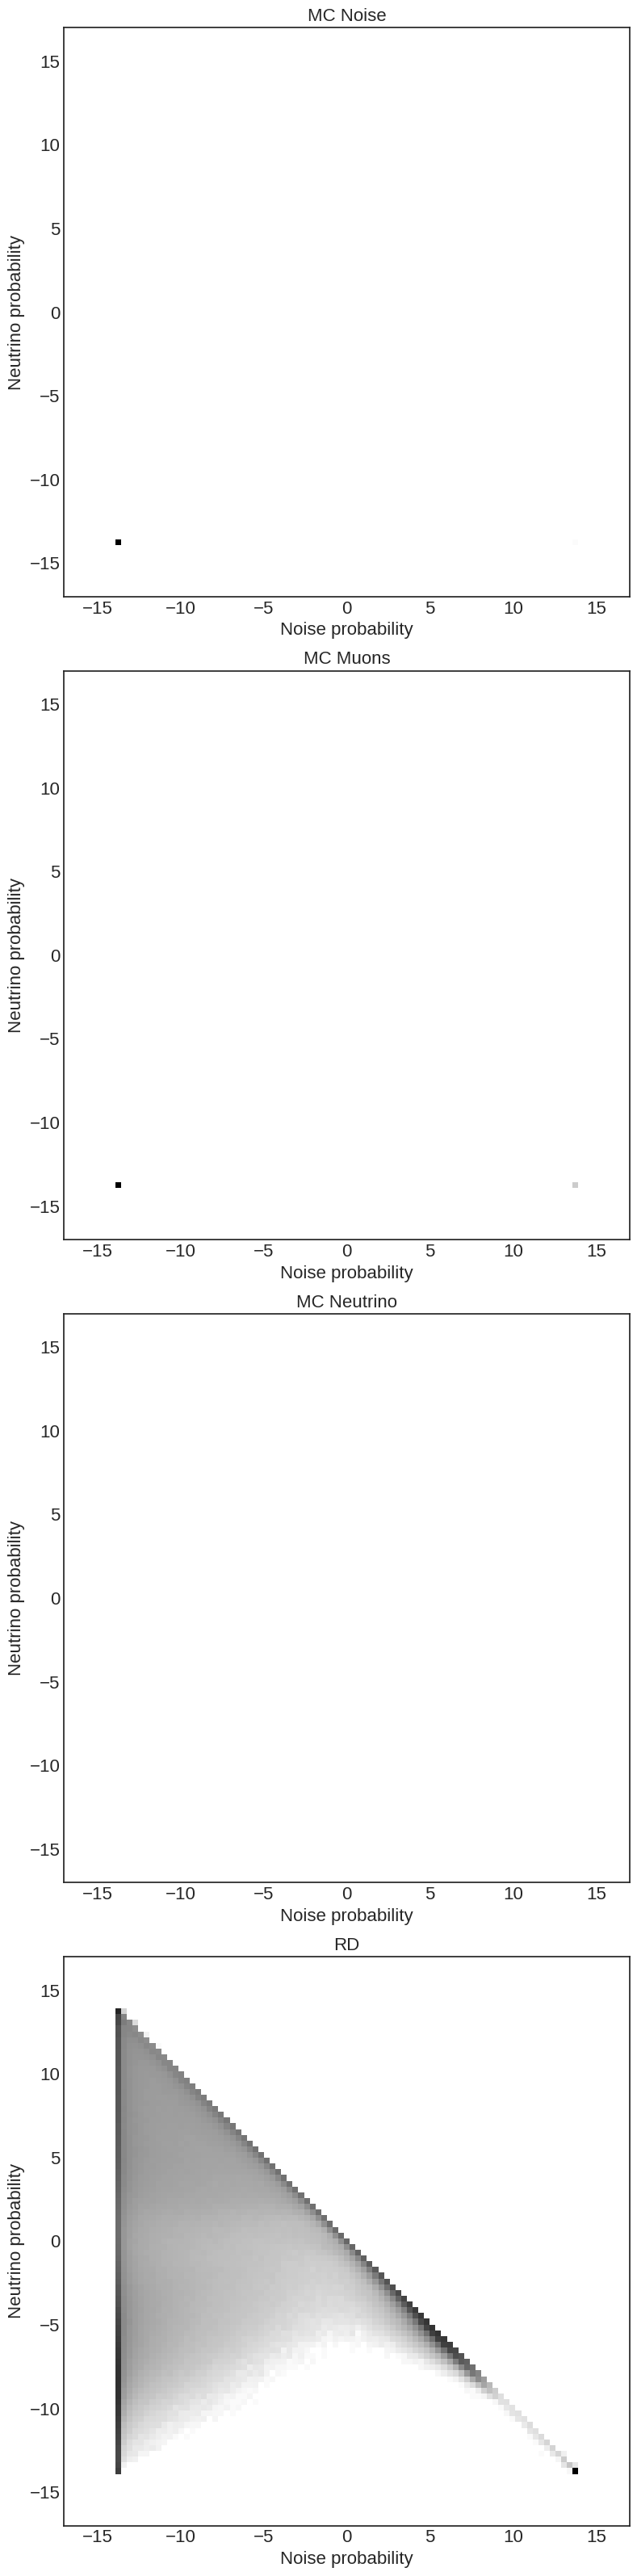

In [26]:
fig, axs = plt.subplots(4,1,sharex=False,figsize=(8, 32))

counts_noise,_,_,_ = axs[0].hist2d(noise_logits['noise'],neutrino_logits['noise'],bins_to_use,norm=colors.LogNorm())
counts_muon,_,_,_ = axs[1].hist2d(noise_logits['muon'],neutrino_logits['muon'],bins_to_use,norm=colors.LogNorm())
counts_neutrino,_,_,_ = axs[2].hist2d(noise_logits['neutrino'],neutrino_logits['neutrino'],bins_to_use,norm=colors.LogNorm())
counts_rd,_,_,_ = axs[3].hist2d(noise_logits['RD'],neutrino_logits['RD'],bins_to_use,norm=colors.LogNorm())

xlabel = 'Noise probability'
axs[0].set_xlabel(xlabel)
axs[1].set_xlabel(xlabel)
axs[2].set_xlabel(xlabel)
axs[3].set_xlabel(xlabel)

ylabel = 'Neutrino probability'
axs[0].set_ylabel(ylabel)
axs[1].set_ylabel(ylabel)
axs[2].set_ylabel(ylabel)
axs[3].set_ylabel(ylabel)

axs[0].set_title('MC Noise')
axs[1].set_title('MC Muons')
axs[2].set_title('MC Neutrino')
axs[3].set_title('RD')

fig.tight_layout()

[1. 1. 1.]
True


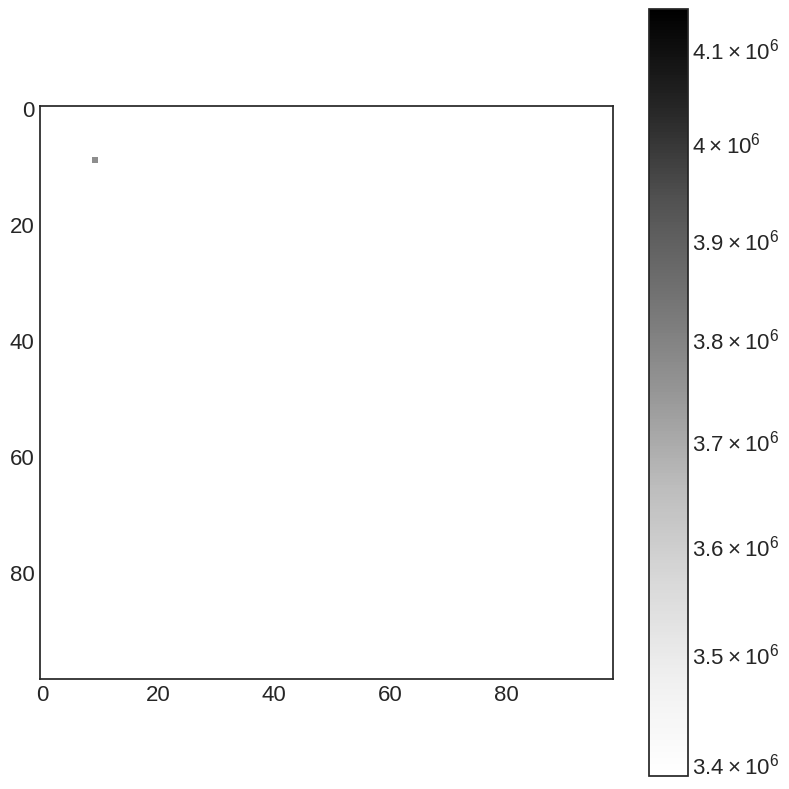

In [27]:
N_0 = [1,1,1]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_fit = counts_noise*res.x[0]#*N_test[0]
counts_muon_fit = counts_muon*res.x[1]#*N_test[1]#
counts_neutrino_fit = counts_neutrino*res.x[2]#*N_test[2]#

counts_residual = counts_noise_fit + counts_muon_fit + counts_neutrino_fit - counts_rd

fig, axs = plt.subplots(figsize=(8, 8))
im = axs.imshow(counts_residual,norm=colors.LogNorm())
fig.colorbar(im, ax=axs)
fig.tight_layout()

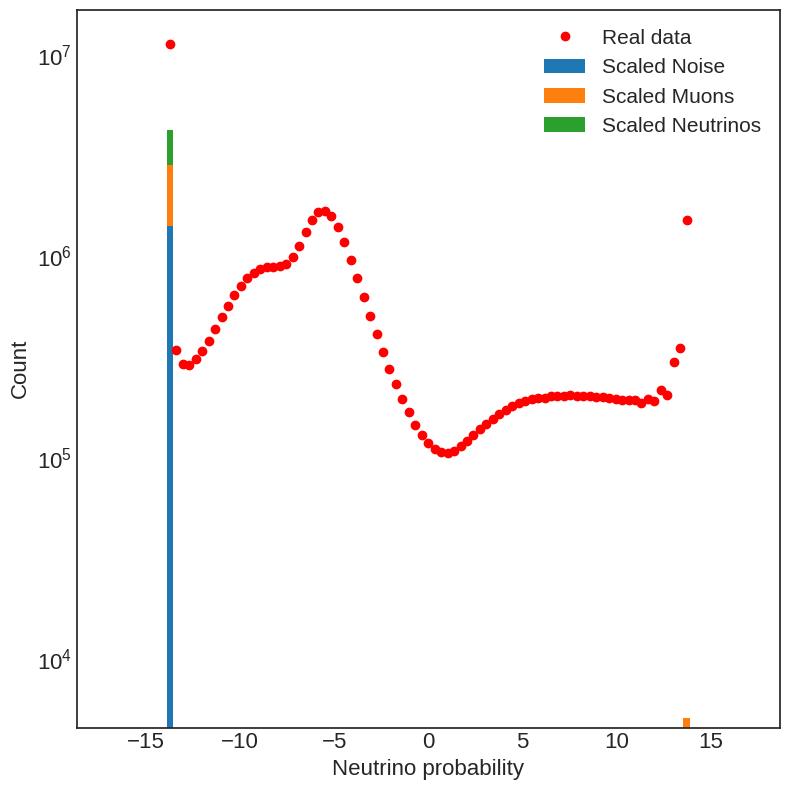

In [28]:
fig, axs = plt.subplots(figsize=(8, 8))

sum_axis=0
bin_width = bins_to_use[1]-bins_to_use[0]

axs.bar(bins_middle,np.sum(counts_noise_fit,axis=sum_axis),width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,np.sum(counts_muon_fit,axis=sum_axis),width=bin_width,bottom=np.sum(counts_noise_fit,axis=sum_axis),label='Scaled Muons')
axs.bar(bins_middle,np.sum(counts_neutrino_fit,axis=sum_axis),width=bin_width,bottom=np.sum(counts_noise_fit+counts_muon_fit,axis=sum_axis),label='Scaled Neutrinos')

axs.plot(bins_middle,np.sum(counts_rd,axis=sum_axis),'o',label='Real data',color='red')
axs.set_xlabel('Neutrino probability')

axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper right')
fig.tight_layout()

there are predicted noise 1420709.0 and predicted muons 1420709.0 and predicted neutrinos 1420709.0


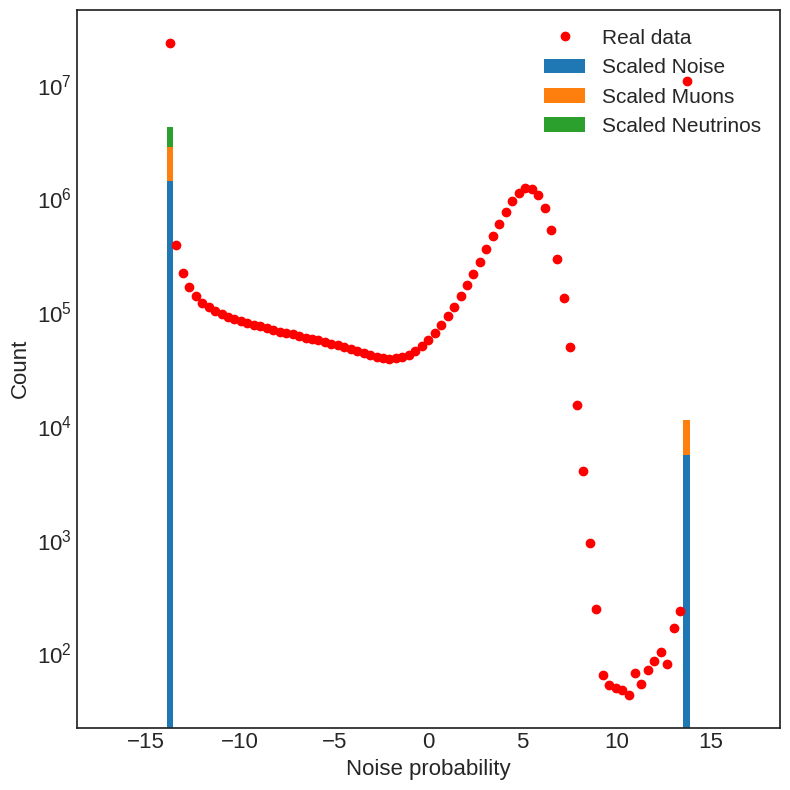

In [23]:
fig, axs = plt.subplots(figsize=(8, 8))

sum_axis=1
bin_width = bins_to_use[1]-bins_to_use[0]

axs.bar(bins_middle,np.sum(counts_noise_fit,axis=sum_axis),width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,np.sum(counts_muon_fit,axis=sum_axis),width=bin_width,bottom=np.sum(counts_noise_fit,axis=sum_axis),label='Scaled Muons')
axs.bar(bins_middle,np.sum(counts_neutrino_fit,axis=sum_axis),width=bin_width,bottom=np.sum(counts_noise_fit+counts_muon_fit,axis=sum_axis),label='Scaled Neutrinos')

axs.plot(bins_middle,np.sum(counts_rd,axis=sum_axis),'o',label='Real data',color='red')
axs.set_xlabel('Noise probability')

axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper right')
fig.tight_layout()

print(f'there are predicted noise {np.sum(counts_noise_fit)}' +f' and predicted muons {np.sum(counts_muon_fit)}' +f' and predicted neutrinos {np.sum(counts_neutrino_fit)}' )
